<a href="https://colab.research.google.com/github/JimenaBaripatti/FeatureEngineering/blob/main/Fire_Categorical_Siqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To review/impute/FE Categorical variables

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# setting up libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import statistics
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency
import math
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from textblob import TextBlob

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline


# Setting working directory
#os.chdir("/content/drive/MyDrive/Colab Notebooks/Data/")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [46]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 232 kB/s 


# Functions

In [3]:
# extract categorical vs. numerical columns
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [37]:
# explore different variables
def exploration_cat(c):

  print('---------------------------------------')

  print('variable name:', c, '\n')
  print('number of categories: ' ,df[c].unique().shape[0], '\n')
  print(df[c].value_counts(normalize=True, dropna=False))

  print('---------------------------------------')

In [39]:
# plot categorical variables
def plot_cat(c):
  plt.figure(figsize=(20,7))
  cat_count=df[c].value_counts(normalize=True) ##dropna=False)
  fig=sns.barplot(100*cat_count.values[0:11], cat_count.index[0:11], alpha=0.9)
  plt.title('Frequency Distribution of ' + str(c))
  plt.xlabel('% occurences', fontsize=12)
  #fig.set_yticklabels(fig.get_yticklabels(),rotation=45, horizontalalignment='right')
  plt.show()


In [6]:
# frequency encoding
def freq_encode(c):
  freq_count=df[c].value_counts(normalize=True).to_dict()
  c_imputed=str(c)+'_imputed'
  df[c_imputed]=df[c].map(freq_count)
  return df

In [7]:
# Impute with the most frequent category
def impute_frequent (c):
  top_cat=df[c].value_counts().nlargest(1).index[0]
  index_to_impute=df[df[c].isnull()].index
  df.at[index_to_impute,c]=top_cat
  return df

In [53]:
# use WOE for categorical variables - feature creation based on the output woe value
def woe_encoder(c,target):
  from category_encoders import WOEEncoder
  x = WOEEncoder()
  x.fit(df[c],df[target])
  df[str(c)+'_encoded']=x.transform(df[c],df[target])
  return df[[c,str(c)+'_encoded']].drop_duplicates().sort_values(by=(str(c)+'_encoded'))

# Load Complete Fire Data


In [9]:
df=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/current_dataset/fire_incident_station_weather_demo_combined.csv', index_col=[0])

In [10]:
df.shape

(17536, 106)

In [ ]:
df.head(2)

In [12]:
#drop unwanted columns
my_not_needed_cols = ['Station_Area', 'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time',
                      'YEAR','TFS_ARR_DAY','TFS_ALM_DAY','TFS_ARR_HOUR','TFS_ALM_HOUR']
# additional numerical columns that are not needed
add_num_cols = ['Incident_Station_Area', 'Incident_Ward','ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'ADDRESS_NUMBER', 'OBJECTID', 'fs_Longitude',
       'fs_Latitude', 'Latitude', 'Longitude']
add_cat_cols = ['Intersection', 'Last_TFS_Unit_Clear_Time','TFS_Alarm_Timeinc_', 
        'TFS_Arrival_Time', 'NAME', 'ADDRESS','LINEAR_NAME_FULL', 'PLACE_NAME', 
        'WARD_NAME', 'MUNICIPALITY_NAME', 'geometry','INCIDENT_DATE',
                'Ext_agent_app_or_defer_time','Fire_Under_Control_Time','location']

fire_not_needed_cols = ['_id_x','_id_y','Exposures']
Demographics_not_needed_cols = ['fsa_imputed','location','FSA']                 
station_not_needed_cols=['ID', 'ADDRESS_ID_LINK', 'X','Y', 'LATITUDE', 'LONGITUDE','POSTAL_CODE','MAINT_STAGE','GENERAL_USE','CLASS_FAMILY_DESC', 'INCIDENT_PERIOD_CAT']
weather_not_needed_cols=['date', 'Incident_Numberdemo','TFS_Alarm_Timedemo']
drop_columns = my_not_needed_cols + add_num_cols + add_cat_cols + Demographics_not_needed_cols + fire_not_needed_cols + station_not_needed_cols + weather_not_needed_cols
df.drop(columns=drop_columns, axis=1,inplace=True)

In [13]:
find_diff_type_var(df)

(Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
        'Extent_Of_Fire', 'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
        'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
        'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread', 'Sprinkler_System_Operation',
        'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival'],
       dtype='object'),
 Index(['Civilian_Casualties', 'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
        'Number_of_responding_apparatus', 'Number_of_responding_personnel',
        'TFS_

# Imputation 

*   Level_of_Origin: impute as '999'
*   'Property_Use', 'Ignition_Source','Material_First_Ignited','Possible_Cause': NLP feature extraction, no imputation needed




In [14]:
# Impute null categorical variable: Level of Origin
#impute with '999' 
df.at[df[df['Level_Of_Origin'].isnull()].index,'Level_Of_Origin']='999'

# Categorical variables overview

In [15]:
cat_var = df.loc[:,df.dtypes == np.object].columns
n_cat = [df[x].unique().shape[0] for x in cat_var]
n_missing=[df[x].isnull().sum() for x in cat_var]

In [16]:
cat_var_summary=pd.DataFrame(data=zip(n_cat,n_missing),index=cat_var, columns=['number of categories','number of missing records']).sort_values(by=['number of categories'], ascending=False)

In [26]:
high_cat=cat_var_summary[cat_var_summary['number of categories']>=20]
med_cat=cat_var_summary[(cat_var_summary['number of categories']>5) & (cat_var_summary['number of categories']<20)]
low_cat=cat_var_summary[cat_var_summary['number of categories']<=5]

In [18]:
#'Incident_Numberinc_' unique key 
cat_var_id=['Incident_Numberinc_']
high_cat=[x for x in high_cat.index if x not in cat_var_id]

In [20]:
cat_var_summary

,number of categories,number of missing records
Incident_Numberinc_,17536,0
Property_Use,284,1
Initial_CAD_Event_Type,115,0
Ignition_Source,85,1913
Area_of_Origin,74,1913
Level_Of_Origin,59,0
Material_First_Ignited,55,1913
Possible_Cause,25,1913
Extent_Of_Fire,13,6322
Smoke_Alarm_at_Fire_Origin_Alarm_Failure,12,6322


In [ ]:
for c in high_cat:
  exploration_cat(c)

In [ ]:
for c in high_cat:
  plot_cat(c)

### High Cardinality categorical variables: 
Level_of_Origin describes the incident origin in terms of floor level. Details can be found via [this](https://www.toronto.ca/ext/open_data/catalog/data_set_files/ofmcodes2009.pdf) link

New feature 'Level_of_Origin_encoded' created using binning:
* 001-003 low_rise_level
* 004-012 mid_rise_level
* 012-100 high_rise_level
* 996 roof
* B - below_grade_level
* the rest including NaN - other



In [21]:
#Level_of_Origin: https://www.toronto.ca/ext/open_data/catalog/data_set_files/ofmcodes2009.pdf
LOO=df['Level_Of_Origin']

In [22]:
LOO_encoded=[None]*len(LOO)
for i in range(len(LOO)):
  try: 
    if int(LOO[i])<=3:
      LOO_encoded[i]='low_rise_level'
    elif int(LOO[i])<=12:
      LOO_encoded[i]='mid_rise_level'
    elif int(LOO[i])<=100:
      LOO_encoded[i]='high_rise_level'
    elif int(LOO[i])==996:
      LOO_encoded[i]='roof'
    else:
      LOO_encoded[i]='other'
  except:
    LOO_encoded[i]='below_grade_level'
print(LOO_encoded[0:50])

['other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'other', 'other', 'low_rise_level', 'high_rise_level', 'low_rise_level', 'other', 'other', 'other', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'mid_rise_level', 'other', 'other', 'mid_rise_level', 'other']


In [23]:
df['Level_of_Origin_encoded']=LOO_encoded

## Med Cardinality: 


*   Variables with #missing records=1914: Status_of_Fire_ON_Arrival and Method_Of_Fire_Control
*   Rest with #missing records=6322



In [28]:
med_cat

,number of categories,number of missing records
Extent_Of_Fire,13,6322
Smoke_Alarm_at_Fire_Origin_Alarm_Failure,12,6322
Smoke_Spread,11,6322
Status_of_Fire_On_Arrival,9,1914
Sprinkler_System_Operation,8,6322
Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,8,6322
Business_Impact,8,6322
Building_Status,8,6320
Fire_Alarm_System_Impact_on_Evacuation,8,6322
Smoke_Alarm_at_Fire_Origin_Alarm_Type,7,6322


In [24]:
med_cat=[x for x in med_cat.index if x not in cat_var_id]
for c in med_cat:
  exploration_cat(c)

---------------------------------------
variable name: Extent_Of_Fire 

number of categories:  13 

NaN                                                                                 0.360516
1 - Confined to object of origin                                                    0.292142
2 - Confined to part of room/area of origin                                         0.232892
3 - Spread to entire room of origin                                                 0.027429
4 - Spread beyond room of origin, same floor                                        0.026745
9 - Confined to roof/exterior structure                                             0.019503
7 - Spread to other floors, confined to building                                    0.015625
11 - Spread beyond building of origin, resulted in exposure fire(s)                 0.006843
8 - Entire Structure                                                                0.005646
99 - Undetermined                                              

## Med Cardinality: Extent_of_Fire and Method_of_Fire_Control


*   Impute missing value
*   Calculate WOE for each category



In [ ]:
df.at[df[df['Level_Of_Origin'].isnull()].index,'Level_Of_Origin']='999'

In [34]:
#imputation
#Extent_of_Fire: missing imputed as '99 - Undetermined'
#Method_of_Fire_Control: missing imputed as '6 - Unknown'

df.at[df[df['Extent_Of_Fire'].isnull()].index,'Extent_Of_Fire']='99 - Undetermined'
df.at[df[df['Method_Of_Fire_Control'].isnull()].index,'Method_Of_Fire_Control']='6 - Unknown'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


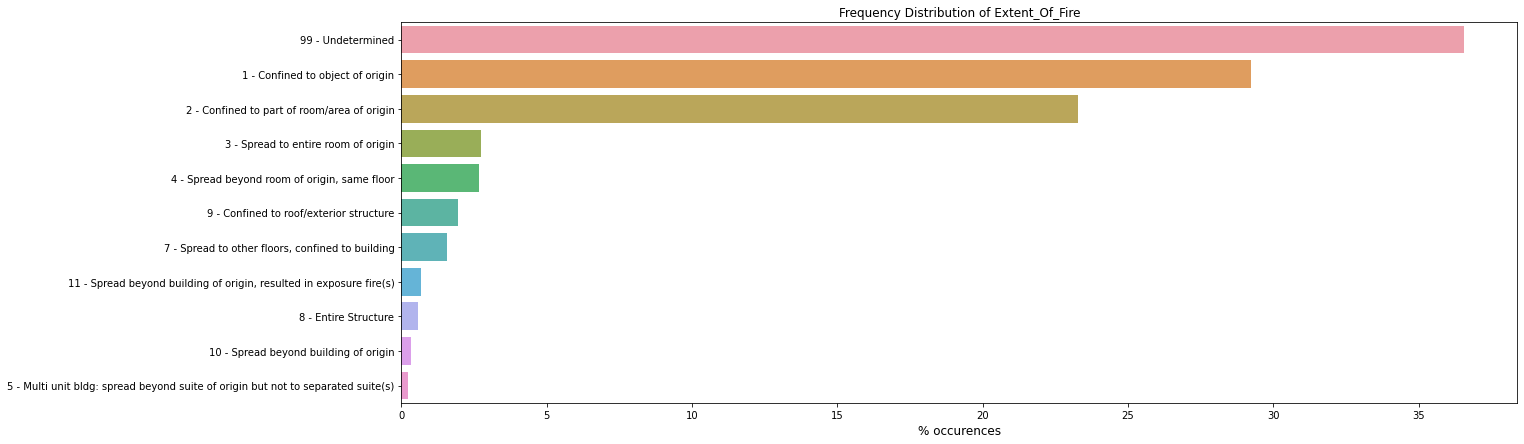

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


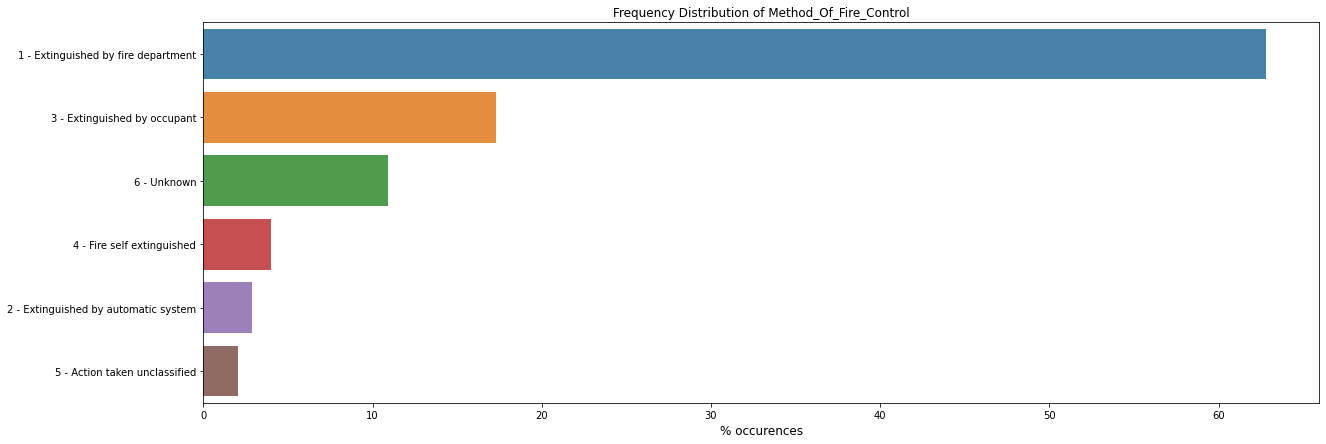

In [42]:
for c in ['Extent_Of_Fire','Method_Of_Fire_Control']:
  plot_cat(c)

In [47]:
#apply woe
woe_encoder('Extent_Of_Fire','LABEL')


,Extent_Of_Fire,Extent_Of_Fire_woe
0,99 - Undetermined,-2.076586
181,8 - Entire Structure,-1.090876
51,9 - Confined to roof/exterior structure,-0.509132
3,1 - Confined to object of origin,-0.189152
48,10 - Spread beyond building of origin,-0.097624
44,"11 - Spread beyond building of origin, resulted in exposure fire(s)",0.280933
6,2 - Confined to part of room/area of origin,0.649791
154,"7 - Spread to other floors, confined to building",1.093445
2289,6 - Multi unit bldg: spread to separate suite(s),1.201659
254,5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s),1.335190


In [48]:
woe_encoder('Method_Of_Fire_Control','LABEL')

,Method_Of_Fire_Control,Method_Of_Fire_Control_woe
2,6 - Unknown,-4.746376
23,2 - Extinguished by automatic system,-0.434780
0,1 - Extinguished by fire department,-0.041407
38,5 - Action taken unclassified,0.203972
13,4 - Fire self extinguished,0.320036
11,3 - Extinguished by occupant,0.596192


## Med Cardinality: Smoke/Sprinkler etc


*   13 variables are missing (#=6322) together, impute using the same strategy and calculate woe
*   



In [52]:
df.head(2)

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,Level_of_Origin_encoded,Extent_Of_Fire_woe,Method_Of_Fire_Control_woe
0,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,99 - Undetermined,01 - Fire,NaN,NaN,NaN,999 - Undetermined,F18020956,Vehicle Fire,999,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",0,0,13705.717515,6,1,2,5.7,28.333,1,0,0,0,0,0.96,0.77,5.1,-3.415,71.47,18.39,1411.27,0.066034,0.175848,39.6,38.3,0.490844,other,-2.076586,-0.041407
1,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,99 - Undetermined,01 - Fire,NaN,NaN,NaN,999 - Undetermined,F18020969,Fire - Grass/Rubbish,999,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,0,0,13691.564674,6,1,2,4.8,6.450,1,0,0,0,0,0.96,0.77,5.1,-3.415,71.47,18.39,7581.15,0.036021,0.682775,39.9,37.0,0.469236,other,-2.076586,-0.041407


In [49]:
# explore data with missing smoke
missing_smoke=df[df['Smoke_Alarm_at_Fire_Origin'].isnull()]

In [50]:
missing_smoke.shape

(6322, 58)

In [51]:
#check missingness
missing_smoke.select_dtypes(include='object').isnull().sum().sort_values()

Level_of_Origin_encoded                                          0   
Extent_Of_Fire                                                   0   
Final_Incident_Type                                              0   
Method_Of_Fire_Control                                           0   
Level_Of_Origin                                                  0   
Initial_CAD_Event_Type                                           0   
Incident_Numberinc_                                              0   
Property_Use                                                     1   
Possible_Cause                                                   1913
Area_of_Origin                                                   1913
Ignition_Source                                                  1913
Material_First_Ignited                                           1913
Status_of_Fire_On_Arrival                                        1914
Building_Status                                                  6320
Fire_Alarm_System_Pr

In [55]:
# these are the variables that are missing together -> consider imputing them using the same strategy
smoke_variables=missing_smoke.select_dtypes(include='object').isnull().sum().nlargest(n=13).index

In [59]:
missing_smoke['Property_Use'].value_counts(normalize=True,dropna=False).nlargest(n=20)

901 - Automobile                                                                 0.228251
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.149003
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.117210
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.074976
902 - Small Truck (eg. pick-up, van, etc.)                                       0.057735
898 - Other property non structure not classified                                0.030528
891 - Outdoor general auto parking                                               0.028472
301 - Detached Dwelling                                                          0.026574
903 - Large Truck (Excluding Truck Trailer)                                      0.026099
323 - Multi-Unit Dwelling - Over 12 Units                                        0.023727
837 - Vehicles or Vehicle Parts                                                  0.022303
846 - Hydr

In [61]:
missing_smoke['Level_Of_Origin'].value_counts(normalize=True,dropna=False).nlargest(n=20)

999    1.0
Name: Level_Of_Origin, dtype: float64

In [62]:
print(smoke_variables)



Index(['Business_Impact', 'Fire_Alarm_System_Impact_on_Evacuation',
       'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence',
       'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Building_Status',
       'Status_of_Fire_On_Arrival'],
      dtype='object')


In [66]:
# impute with appropriate logic
df.at[df[df['Smoke_Alarm_at_Fire_Origin_Alarm_Failure'].isnull()].index,'Smoke_Alarm_at_Fire_Origin_Alarm_Failure']='98 - Not applicable: Alarm operated OR presence/operation undetermined'
df.at[df[df['Status_of_Fire_On_Arrival'].isnull()].index,'Status_of_Fire_On_Arrival']='Not applicable'
df.at[df[df['Smoke_Spread'].isnull()].index,'Smoke_Spread']='Not applicable'
df.at[df[df['Sprinkler_System_Operation'].isnull()].index,'Sprinkler_System_Operation']='8 - Not applicable - no sprinkler system present'
df.at[df[df['Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation'].isnull()].index,'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation']='Not applicable'
df.at[df[df['Business_Impact'].isnull()].index,'Business_Impact']='8 - Not applicable (not a business)'
df.at[df[df['Fire_Alarm_System_Impact_on_Evacuation'].isnull()].index,'Fire_Alarm_System_Impact_on_Evacuation']='Not applicable'
df.at[df[df['Smoke_Alarm_at_Fire_Origin_Alarm_Type'].isnull()].index,'Smoke_Alarm_at_Fire_Origin_Alarm_Type']='8 - Not applicable - no smoke alarm or presence undetermined'
df.at[df[df['Smoke_Alarm_at_Fire_Origin'].isnull()].index,'Smoke_Alarm_at_Fire_Origin']='Not applicable'
df.at[df[df['Fire_Alarm_System_Operation'].isnull()].index,'Fire_Alarm_System_Operation']='8 - Not applicable (no system)'
df.at[df[df['Sprinkler_System_Presence'].isnull()].index,'Sprinkler_System_Presence']='9 - Undetermined'
df.at[df[df['Fire_Alarm_System_Presence'].isnull()].index,'Fire_Alarm_System_Presence']='2 - No Fire alarm system'
df.at[df[df['Building_Status'].isnull()].index,'Building_Status']='08 - Not Applicable'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


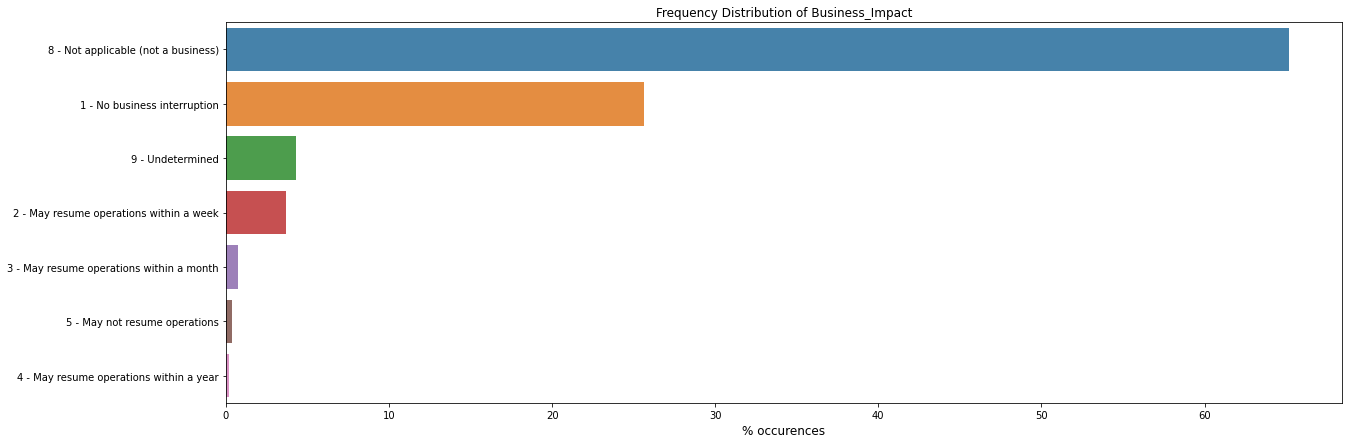

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


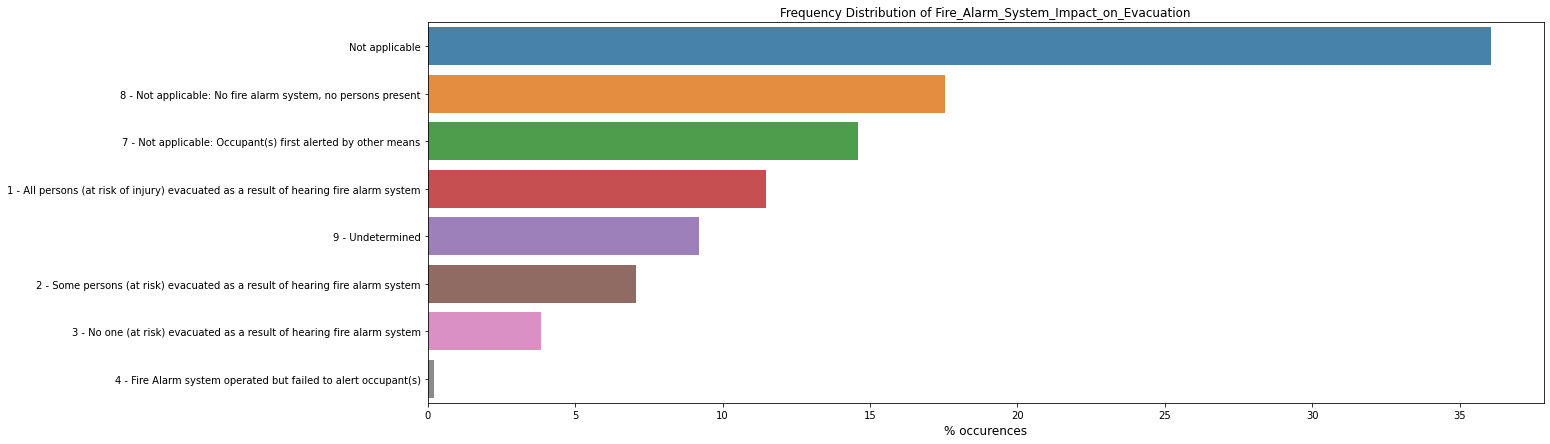

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


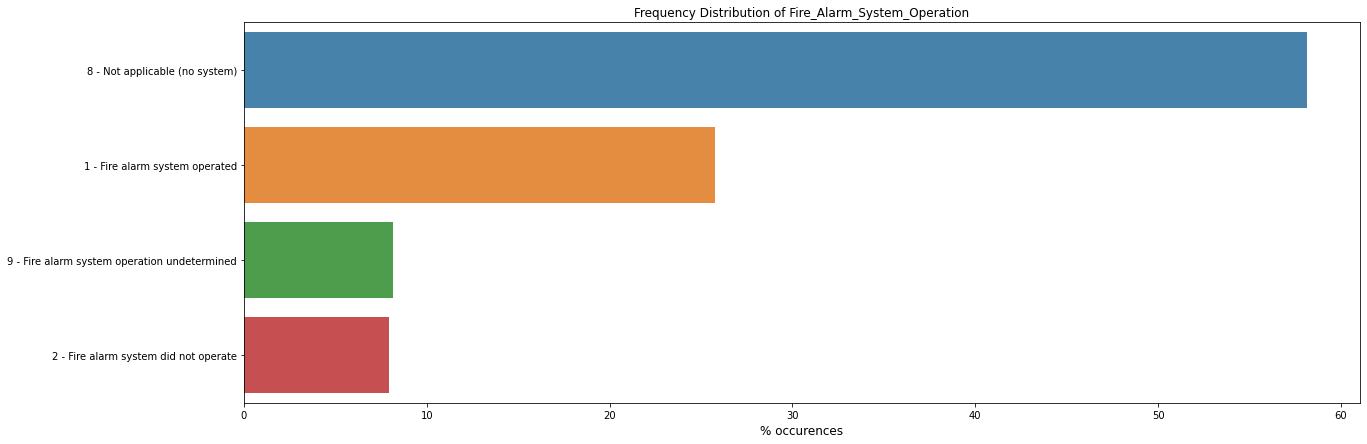

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


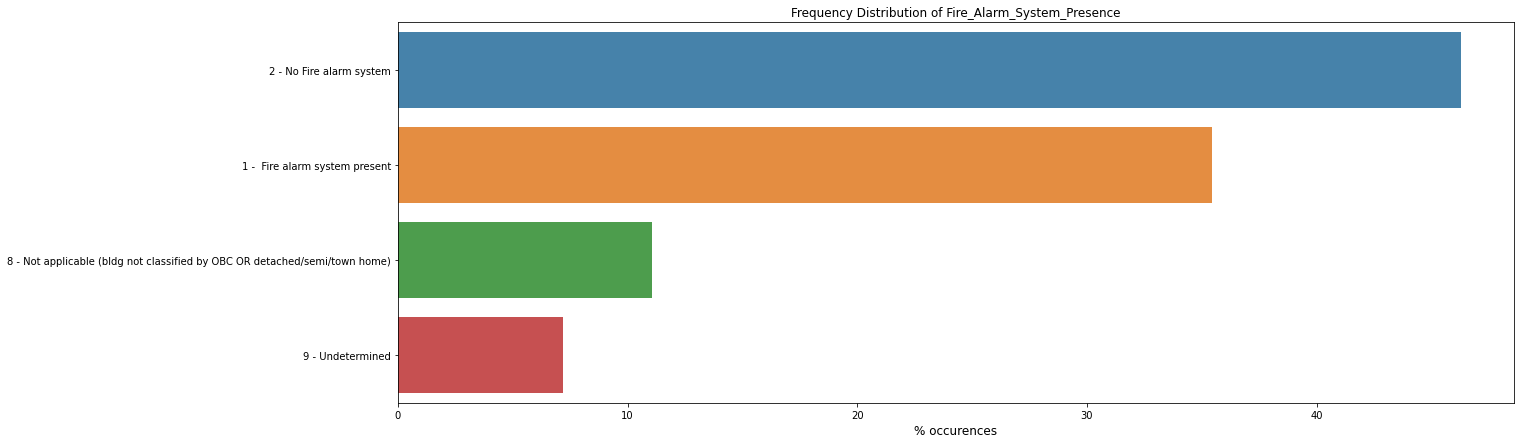

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


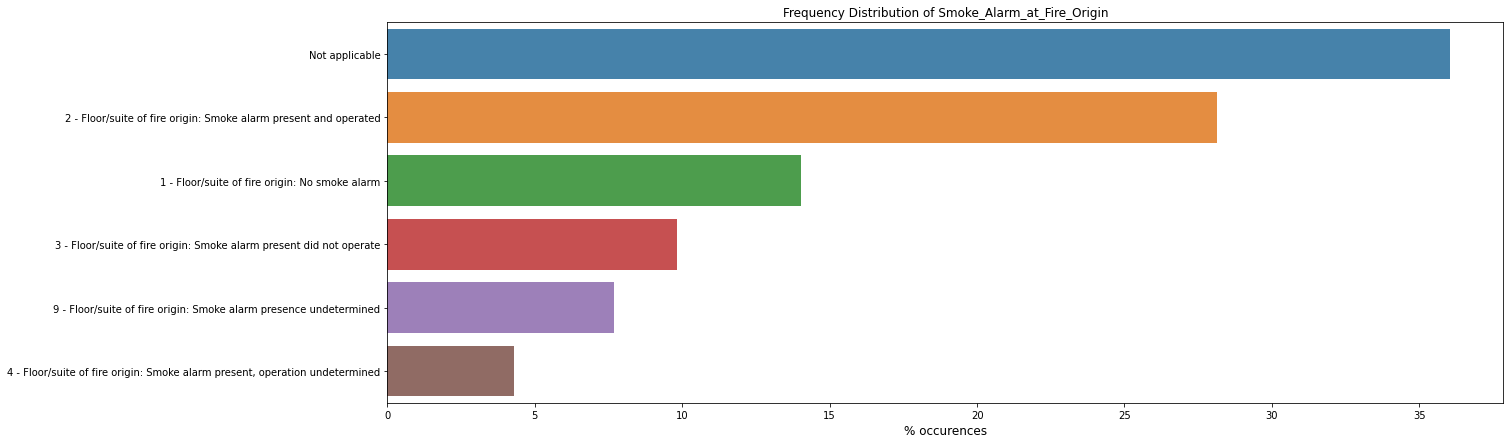

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


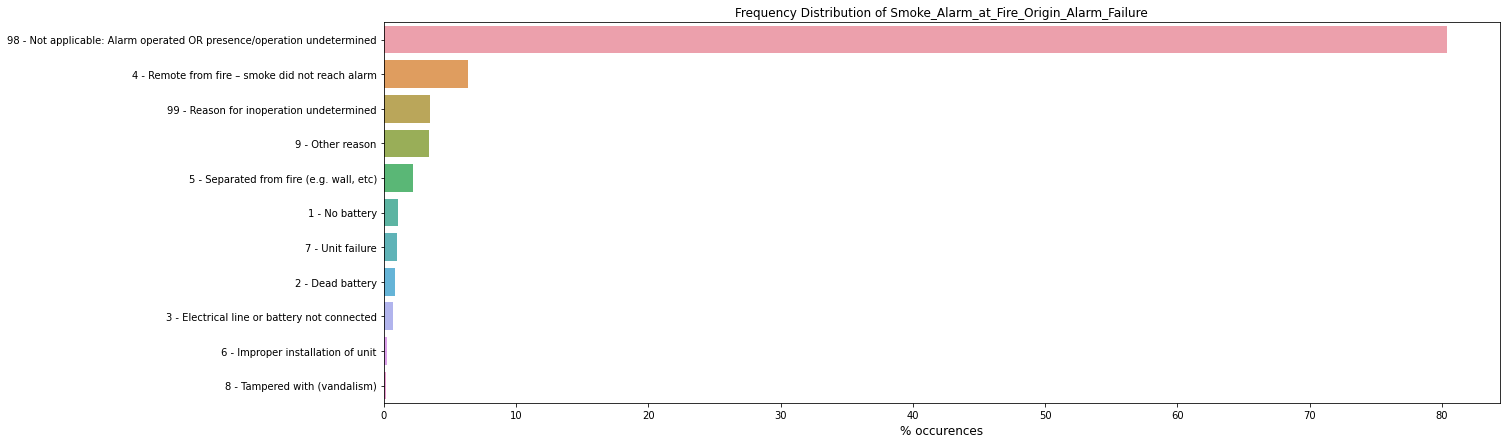

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


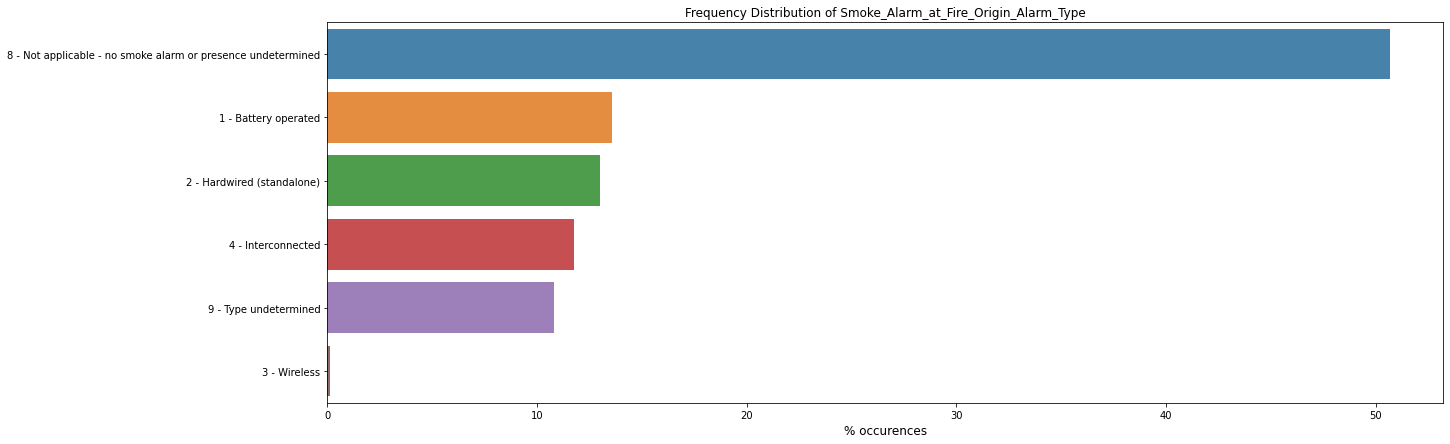

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


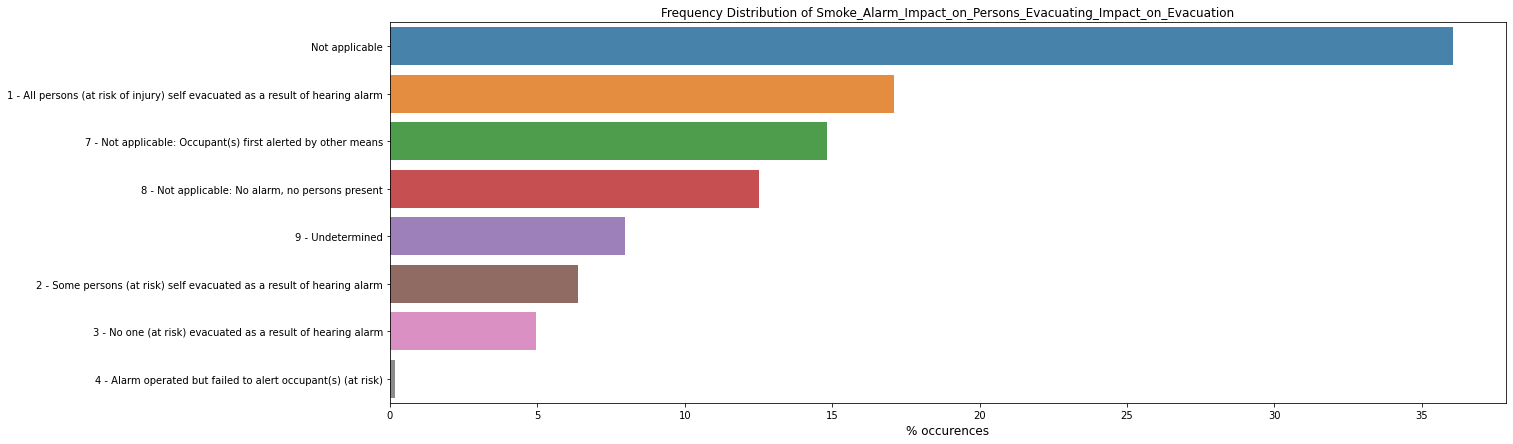

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


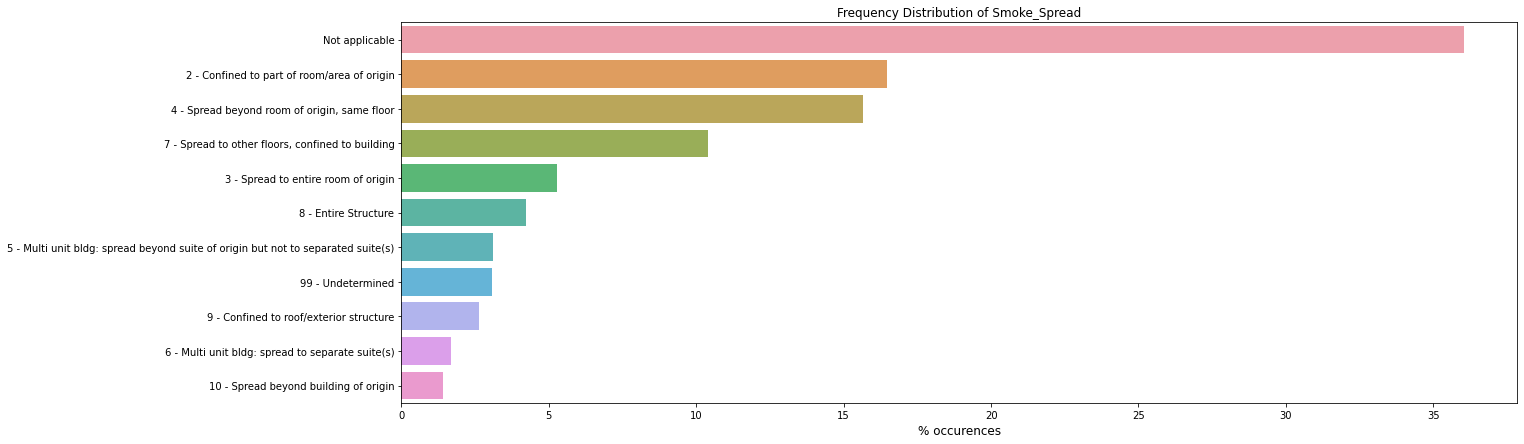

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


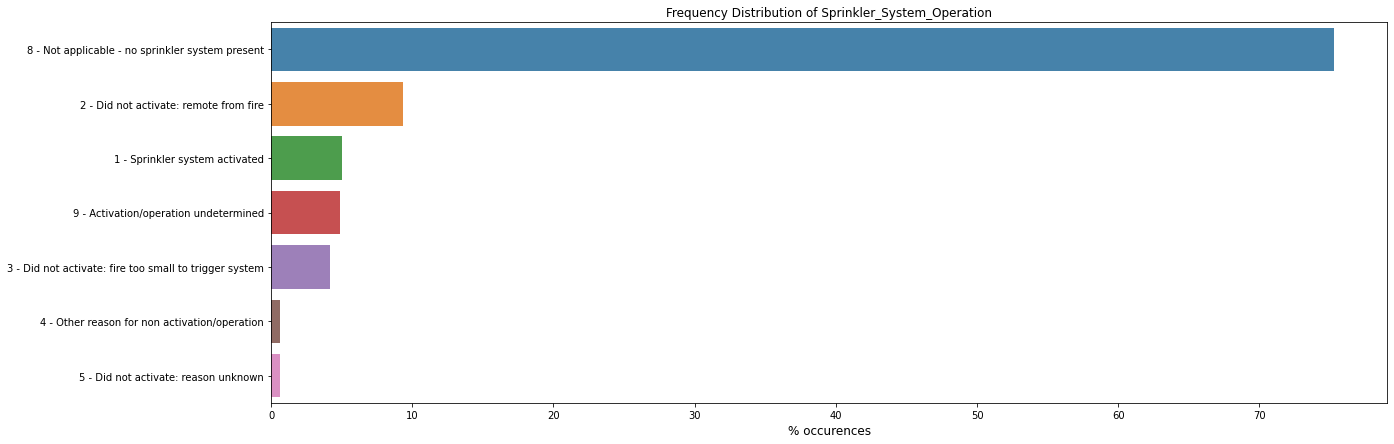

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


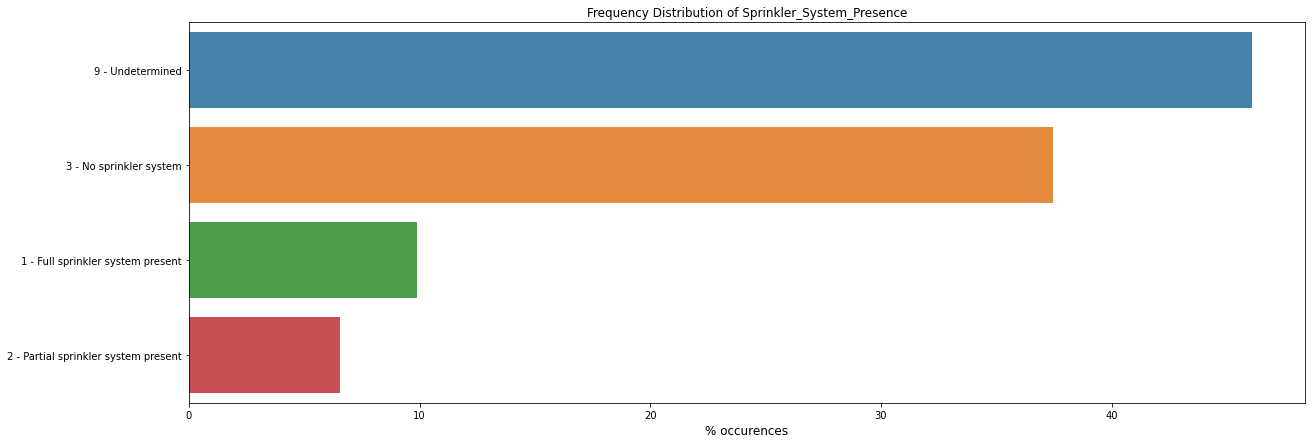

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


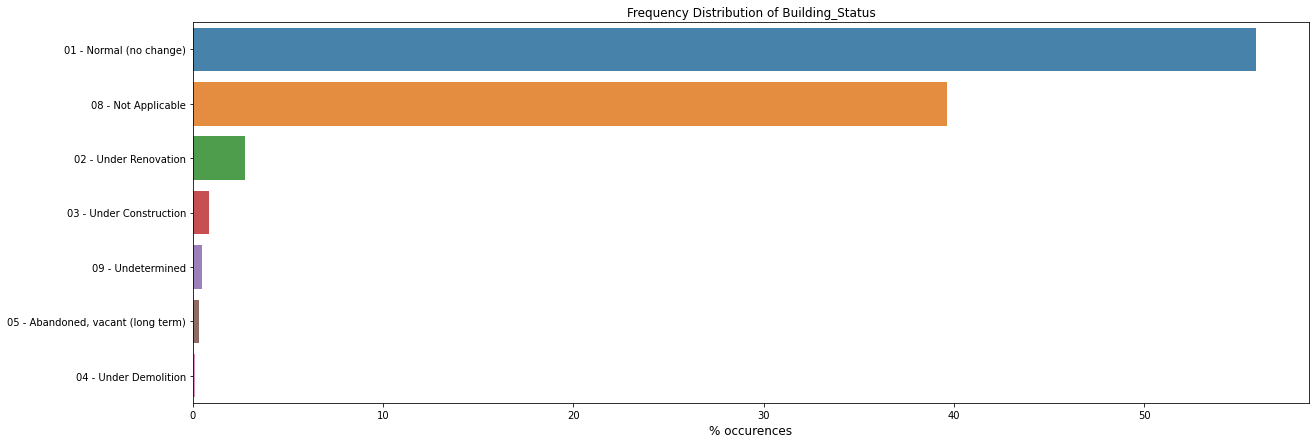

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


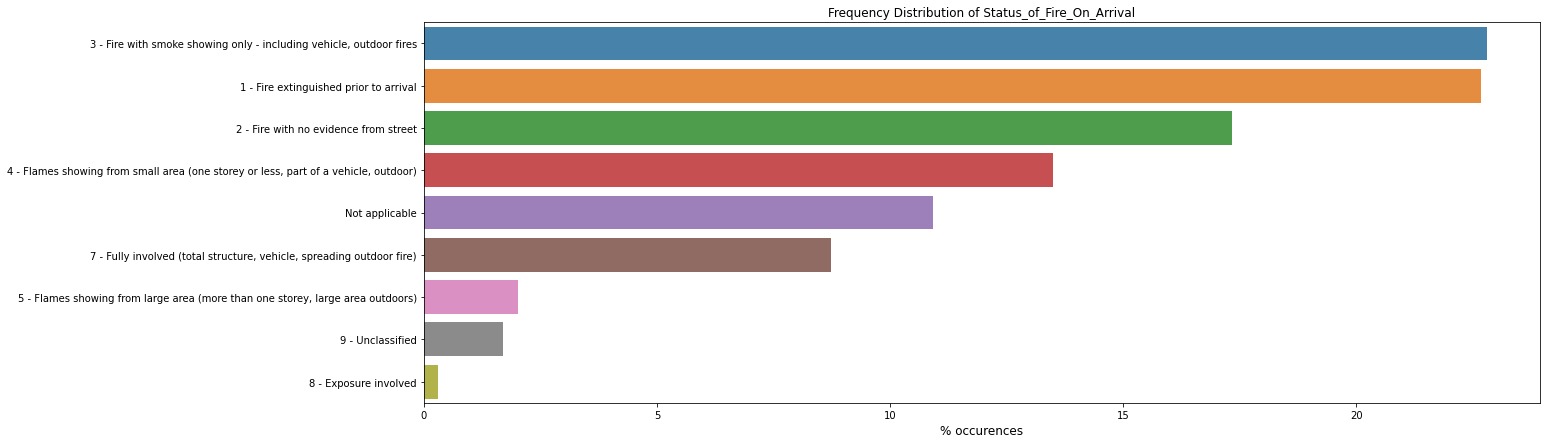

In [68]:
for c in smoke_variables:
  plot_cat(c)